# Check the Al K$\alpha$ line at 1.486 keV in all EPIC-PN Large Window observations

**Note:** it will only explore the boresight, i.e. CCD#4

In [25]:
import os
import sys
import numpy as np
from datetime import datetime

from astropy.io import fits
from astropy.table import Table
from astropy.convolution import convolve, Box1DKernel

from lmfit.models import GaussianModel, PolynomialModel

%matplotlib inline
import matplotlib.pylab as plt

import seaborn as sns
sns.set(style="white")

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

home = os.path.expanduser('~')
#sys.path.append(home + '/IVAN/python')

#from xmm_tools import read_pn_obstable, fit_cu_line, run_command


In [78]:
def fit_xline(xin,yin, minMax=(7.0,9.0),line_c=8.0,line_sig=30.0,verbose=False):
    #
    # PURPOSE:
    #   Fit the Cu Ka line (8.04 keV), the model is a polynomial(2) + a Gaussian line.
    #
    # INPUTS:
    #   xin is the energy channel (in keV)
    #   yin is the counts
    #   line_c is the initial energy of the line (in keV)
    #   line_sig is the initial Gaussian line sigma (in eV), if None then unconstrained, 
    #         else within +/- 200 eV
    #   minMax is a tuple (in keV) of the energy limits to consider for the model and the fit
    #
    # OUTPUTS:
    #  a tuple of the full fit output class and the results line in ascii.
    #
    # NOTES:
    #   the Gaussian sigma of the line is only allowed within a certain range: 80 to 250 eV
    #
    #
    m1 = xin >= minMax[0]
    m2 = xin <= minMax[1]
    xw = xin[m1*m2]
    yw = yin[m1*m2]
    i1max = np.argmax(yw)
    #y1max = yw[i1max]
    y1max = 10.0
    #x1max = xw[i1max]
    #
    poly_mod = PolynomialModel(1,prefix='poly_')
    pars = poly_mod.guess(yw, x=xw)
    #
    gauss1  = GaussianModel(prefix='g1_')
    pars.update( gauss1.make_params())
    #
    pars['g1_center'].set(line_c,min=line_c-0.2,max=line_c+0.1)
    pars['g1_amplitude'].set(y1max,min=0.0,max=y1max)
    if (line_sig != None):
        # in keV
        sig = line_sig/1000.0
        sig_min = min(0.01,sig)
        sig_max = sig + 0.02
        pars['g1_sigma'].set(sig,min=sig_min,max=sig_max)
    else:
        sig = 0.1 # keV 
        pars['g1_sigma'].set(sig)
    if (verbose): 
        print ("Initial parameters: ",pars)
    #
    mod = poly_mod + gauss1
    #init = mod.eval(pars, x=x)
    out = mod.fit(yw, pars, x=xw)
    #
    if (verbose):
        print (out)
    cen = out.params['g1_center'].value
    cen_err = out.params['g1_center'].stderr
    fwhm = out.params['g1_fwhm'].value
    fwhm_err = out.params['g1_fwhm'].stderr
    #peak = out.params['g1_amplitude'].value/expo1
    #peak_err = out.params['g1_amplitude'].stderr/expo1
    chi2 = out.chisqr
    df = len(xw)
    try:
        results  = f"{cen:.3f},{cen_err:.3f},{fwhm:.5f},{fwhm_err:.5f},{chi2:.3f},{df}"
    except:
        results = None
    #
    return (out,results)


In [79]:
outputDir = home + '/IVAN/Al-line'
cuDir = home + '/IVAN/Cu-line'
plotDir = home + '/IVAN/Al-line/plots'
#
# this is just to get the list of OBS_IDs to process
#
t = Table.read(f"{cuDir}/fit_results_cuka.csv")
obslist = np.unique(t['obsid'])
#obslist = [804680101]
nw = len(obslist)
#
# relative times
time0 = datetime.strptime("2000-01-01T00:00:00","%Y-%m-%dT%H:%M:%S")
#
# products versions to read/write
#
vers = "cti50"

Doing OBS_ID: 0550950101 (18/69)
Initial parameters:  Parameters([('poly_c0', <Parameter 'poly_c0', 224.08014383527902, bounds=[-inf:inf]>), ('poly_c1', <Parameter 'poly_c1', -75.31047731638839, bounds=[-inf:inf]>), ('g1_sigma', <Parameter 'g1_sigma', 0.03, bounds=[0.01:0.05]>), ('g1_center', <Parameter 'g1_center', 1.48, bounds=[1.28:1.58]>), ('g1_amplitude', <Parameter 'g1_amplitude', 10.0, bounds=[0.0:10.0]>), ('g1_fwhm', <Parameter 'g1_fwhm', 0.0706446, bounds=[-inf:inf], expr='2.3548200*g1_sigma'>), ('g1_height', <Parameter 'g1_height', 132.98076666666668, bounds=[-inf:inf], expr='0.3989423*g1_amplitude/max(1.e-15, g1_sigma)'>)])
{'g1_sigma': 0.03, 'g1_center': 1.479321553460878, 'g1_amplitude': 3.2274759701930815, 'poly_c0': 221.61752315423965, 'poly_c1': -74.89095896272806}


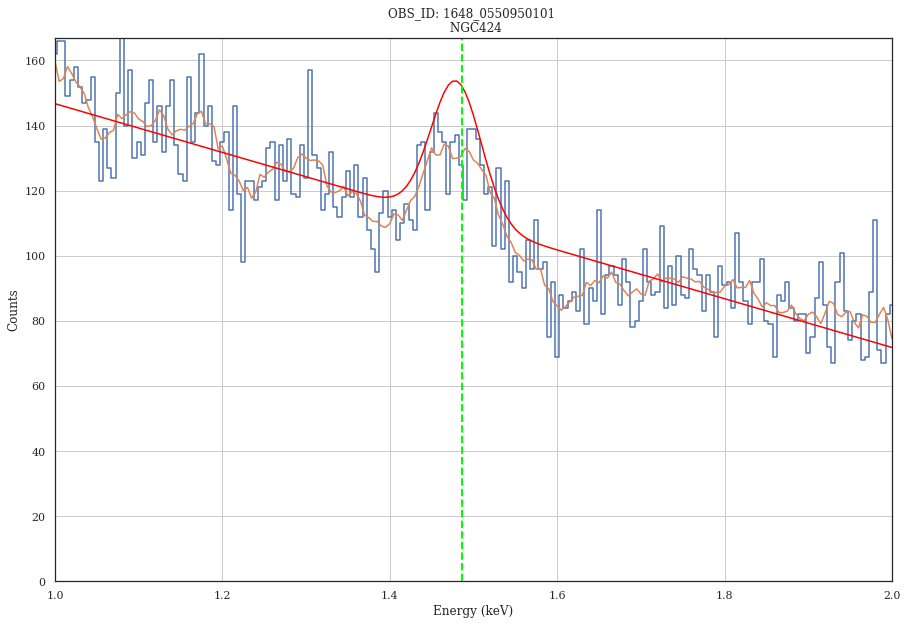

All done


In [80]:
#
# output file
#
#fout = open(f"{outputDir}/fit_results_alka_{vers}.csv","w")
#
#print ("obsid,rev,delta_time,ontime,ccd,lineE,lineE_err,fwhm,fwhm_err,chi2,df",file=fout)
#
ncol = 3
nrows = int(nw/ncol)
# energy limits for the fitting, in keV
limits = (1.0,2.0)
#
kj = 0
k = 0
for ik,iobs in enumerate(obslist):
    obsid = f"{iobs:010}"
    #if (obsid != "0205680101"):
    if (obsid != "0550950101"):
        continue
    print (f"Doing OBS_ID: {obsid} ({ik+1}/{nw})")
    # Now fit
    smooth = 7
    ccd = "04"
    slices = f"{cuDir}/{obsid}/{vers}/pn_{ccd}_all_spec5.fits"
    if (not os.path.isfile(slices)):
        raise FileNotFoundError
    #
    hdu = fits.open(slices)
    #
    target = hdu[0].header["OBJECT"]
    rev = hdu[0].header["REVOLUT"]
    start_time = hdu[0].header['DATE-OBS']
    stime = datetime.strptime(start_time,"%Y-%m-%dT%H:%M:%S")
    delta_time = (stime-time0).total_seconds()/(365.0*24.0*3600.0) # in years
    #
    spec = hdu['SPECTRUM']
    ontime = spec.header["EXPOSURE"]
    channel = spec.data['CHANNEL']*5.0/1000.0
    counts = spec.data['COUNTS']
    hdu.close()
    #
    y = convolve(counts, Box1DKernel(smooth))
    # now fit a simple linear + Gauss line model
    #
    (fit_out,fit_res) = fit_xline(channel,counts,minMax=limits,line_c=1.48,line_sig=30.0,verbose=True)
    #(fit_out,fit_res) = fit_xline(channel,y,minMax=(1.1,1.9),line_c=1.5,line_sig=300.0,verbose=True)
    print (fit_out.best_values)
    fitted_peak = fit_out.params['g1_height'].value
    #
    # save the results
    #
    #output = f"{obsid},{rev},{delta_time:.4f},{ontime:.2f},{ccd},{fit_res}"
    #print (fit_res)
    #print (output,file=fout)
    #
    yfitted = fit_out.eval(x=channel)
    ymax = np.max(counts[np.where((channel <= limits[1]) & (channel >= limits[0]))])
    #print (f"Fitting CCD #{ccd:02}",fit_res)
    fig, axs = plt.subplots(figsize=(15,10))
    axs.set_title(f"OBS_ID: {rev}_{obsid} \n {target}")
    axs.set_xlabel("Energy (keV)")
    axs.set_ylabel("Counts")
    axs.plot(channel,counts,drawstyle='steps-mid',label=f'CCD #{ccd}')
    axs.plot(channel,y,label='')
    axs.plot(channel,yfitted,color='red',label='')
    axs.axvline(1.486, color='lime',ls='dashed',linewidth=2)
    axs.set_xlim(limits)
    axs.set_ylim((0,ymax))
    axs.grid()
    #axs[kj,k].legend()
    plt.savefig(f"{plotDir}/{rev}_{obsid}_AlKa_{vers}_plot.png",dpi=100)
    plt.show()
    plt.close()
#plt.subplots_adjust(wspace=0, hspace=0)
#plt.text(-13,-1,'Energy (keV)',ha='center', va='center')
#plt.text(-36,10,'Counts',rotation='vertical',ha='center', va='center')
#plt.tight_layout()
#
#fout.close()
print ("All done")

In [57]:
fit_out.best_values

{'g1_sigma': 0.48856707951637646,
 'g1_center': 1.3005925959758973,
 'g1_amplitude': 0.23792553568107222,
 'poly_c0': 223.51177353578012,
 'poly_c1': -74.97546290538453}